In [28]:
import logging
import threading
import itertools
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy as sp
import scipy.fftpack
import skimage as ski  
from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline

In [29]:
# Get stuff in
df_input = pd.read_csv('./Anomaly_Sample_data.csv',
                  parse_dates=['EVT_TIMESTAMP','UPDATED_UTC'])

# and sort it by timestamp
df_input = df_input.sort_values(by='EVT_TIMESTAMP')

df_input.head(3)


,DEVICEID,EVT_TIMESTAMP,DEVICETYPE,LOGICALINTERFACE_ID,EVENTTYPE,FORMAT,UPDATED_UTC,PRESSURE,TEMPERATURE,TURBINE_ID
316,B102,2019-09-26 18:08:11.262975,EnergySystemModel02,NaN,NaN,NaN,2019-09-26 18:08:11.262999,97.384763,77.907810,NaN
315,A101,2019-09-26 18:08:11.262975,EnergySystemModel02,NaN,NaN,NaN,2019-09-26 18:08:11.262999,97.384763,79.333185,NaN
317,A101,2019-09-26 18:18:06.486895,EnergySystemModel02,NaN,NaN,NaN,2019-09-26 18:18:06.486921,94.630009,77.907810,NaN


In [30]:
# start with a single sensor
df_temp = df_input[(df_input.DEVICEID == 'A101')][['EVT_TIMESTAMP','PRESSURE','TEMPERATURE']]

time_raw = df_temp['EVT_TIMESTAMP'].values
#temp_raw = df_temp['TEMPERATURE'].values
# turn timestamp into the index
df_temp = df_temp.set_index('EVT_TIMESTAMP')

#time_raw = df_temp['EVT_TIMESTAMP'].values
temp_raw = df_temp['TEMPERATURE'].values

# fill out the time gaps by backward filling - 2nd order splines are overkill I guess
def custom_resampler(array_like):
    if (array_like.values.size > 0):
        return array_like.values[0]
    return np.nan

upsampledna = df_temp.resample('5min').apply(custom_resampler)
upsampledna['RAW_TEMPERATURE'] = upsampledna['TEMPERATURE']
upsampled = df_temp.resample('5min').bfill()

df_temp = upsampled.interpolate(method='spline', order=2)
#temp_raw = df_temp['TEMPERATURE'].values

# we have 963 data points
#print (len(df_temp), temp_raw.size, time_raw.size)


Text(0, 0.5, 'Temperature - with gaps')

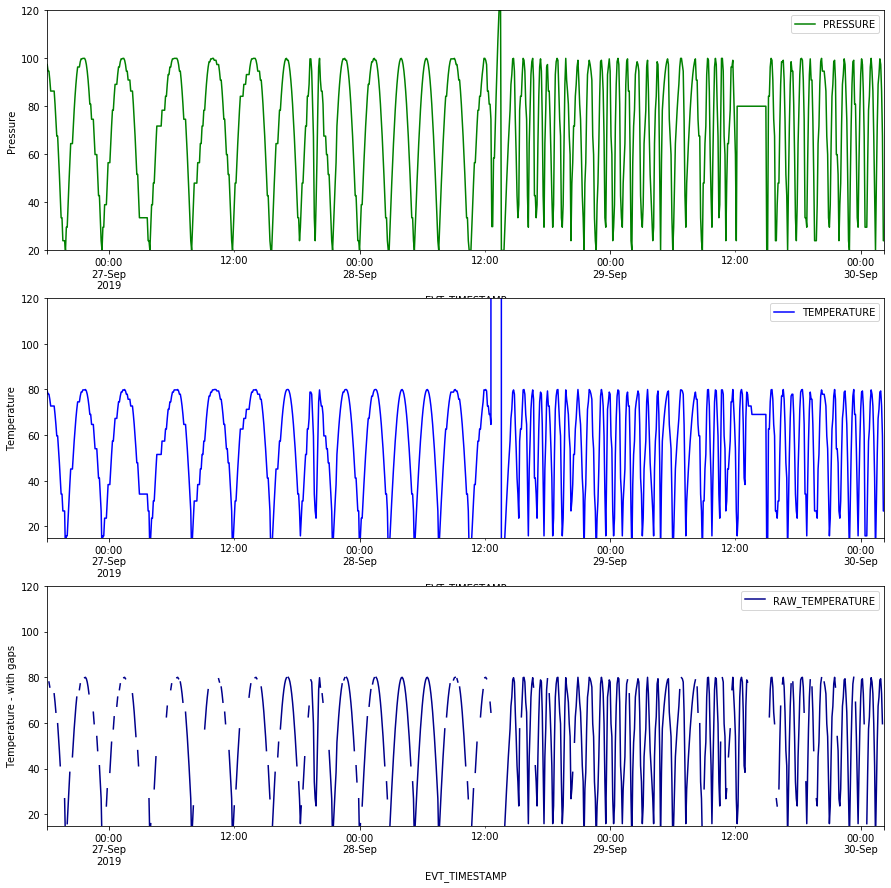

In [44]:
#df_temp = df_input[(df_input.DEVICEID == 'A101')]
#tmin = df_temp.head(1).EVT_TIMESTAMP.astype(np.int64)
#tmax = df_temp.tail(1).EVT_TIMESTAMP.astype(np.int64)
#tdiff = np.subtract(tmax, tmin) // 300000000000  # from nanosec to 5 min steps


fig, ax = plt.subplots(3, 1, figsize=(15, 15))
#df_temp.plot(ax=ax[0], lw=.5, x='EVT_TIMESTAMP', y='PRESSURE')
upsampled.plot(ax=ax[0], lw=1.5, y='PRESSURE', color='green')
#upsampledna.plot(ax=ax[0], lw=1.5, y='PRESSURE',color='blue')
ax[0].set_ylim(20, 120)
#ax[0].set_xlabel('Date')
ax[0].set_ylabel('Pressure')
#df_temp.plot(ax=ax[1], lw=.5, x='EVT_TIMESTAMP', y='TEMPERATURE')
upsampled.plot(ax=ax[1], lw=1.5, y='TEMPERATURE',color='blue')
#upsampledna.plot(ax=ax[1], lw=1.5, y='TEMPERATURE',color='blue')
ax[1].set_ylim(15, 120)
#ax[1].set_xlabel('Date')
ax[1].set_ylabel('Temperature')
upsampledna.plot(ax=ax[2], lw=1.5, y='RAW_TEMPERATURE', color='darkblue')
ax[2].set_ylim(15, 120)
#ax[2].set_xlabel('Date')
ax[2].set_ylabel('Temperature - with gaps')

Text(0, 0.5, 'Temperatur Gap')

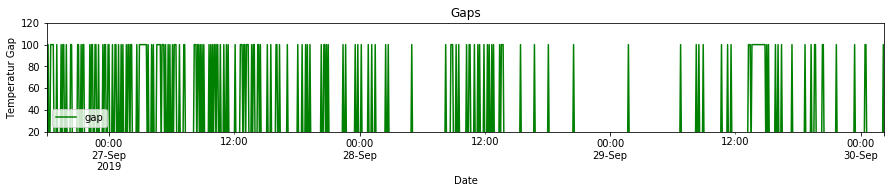

In [43]:
# Dealing with the larger gaps first !
# Transform NaN (gap !) to 
gaps = upsampledna.where(upsampledna.isna(), 0).fillna(100)
gaps['gap'] = gaps['TEMPERATURE']

fig, ax = plt.subplots(1, 1, figsize=(15,2))
#df_temp.plot(ax=ax[0], lw=.5, x='EVT_TIMESTAMP', y='PRESSURE')
gaps.plot(ax=ax, lw=1.5, y='gap', title='Gaps', color='green')
#upsampledna.plot(ax=ax[0], lw=1.5, y='PRESSURE',color='blue')
ax.set_ylim(20, 120)
ax.set_xlabel('Date')
ax.set_ylabel('Temperatur Gap')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


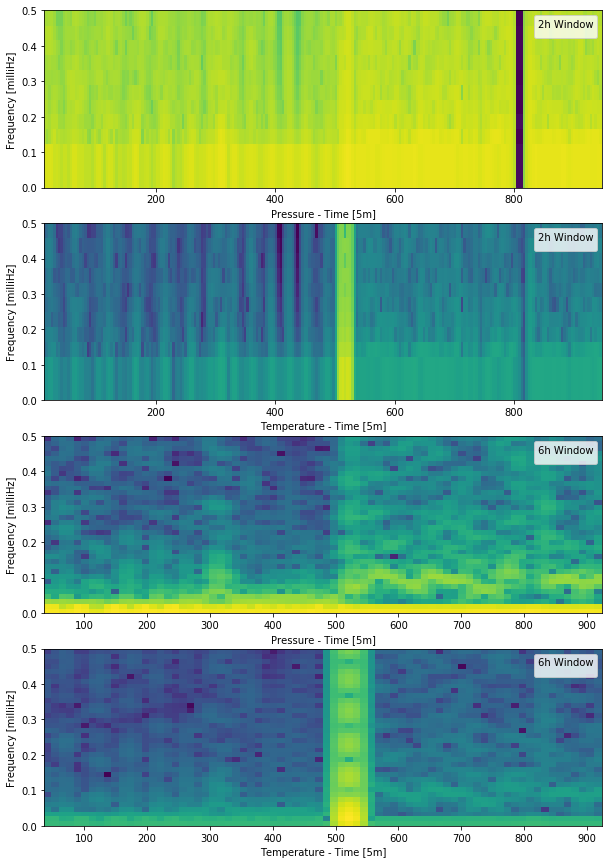

In [33]:
# this is a bit easier
from scipy import signal

df_temp['timestamp'] = df_temp.index
temperature = df_temp[['TEMPERATURE']].to_numpy().reshape(-1,)
pressure = df_temp[['PRESSURE']].to_numpy().reshape(-1,)
#temp_t = df_temp['TEMPERATURE'].values
temp_dt = (df_temp.index.values.astype(np.int64) -1569521100000000000) / 300000000000


rate = 1
MS = 24 # 2hours
ML = 72 # 6hours
freqsPS, timesPS, SxPS = signal.spectrogram(pressure, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - MS/6,
                                      detrend=False, scaling='spectrum')
freqsTS, timesTS, SxTS = signal.spectrogram(temperature, fs=rate, window='hanning',
                                      nperseg=MS, noverlap=MS - MS/6,
                                      detrend=False, scaling='spectrum')
freqsPL, timesPL, SxPL = signal.spectrogram(pressure, fs=rate, window='hanning',
                                      nperseg=ML, noverlap=ML - ML/6,
                                      detrend=False, scaling='spectrum')
freqsTL, timesTL, SxTL = signal.spectrogram(temperature, fs=rate, window='hanning',
                                      nperseg=ML, noverlap=ML - ML/6,
                                      detrend=False, scaling='spectrum')
# cut off frequencies too low to fit into the window the window

freqsPSb = (freqsPS > 2/MS).astype(int)
freqsTSb = (freqsTS > 2/MS).astype(int)
#freqsPSb = (freqsPS in range(0.4, 0.5)).astype(int)

freqsPS = freqsPS * freqsPSb
freqsTS = freqsTS * freqsTSb

#EPS = np.dot(SxPS.T, freqsPS)
#EPS = np.log10(np.dot(SxPS.T, freqsPS))
EPS = np.log10(np.dot(SxPS.T, freqsPS))
ETS = np.log10(np.dot(SxTS.T, freqsTS))

f, ax = plt.subplots(4,1,figsize=(10,15))
ax[0].pcolormesh(timesPS, freqsPS, 10 * np.log10(SxPS)) #, cmap='coolwarm')
ax[0].set_ylabel('Frequency [milliHz]')
ax[0].set_xlabel('Pressure - Time [5m]')
ax[0].legend(title='2h Window')

ax[1].pcolormesh(timesTS, freqsTS, 10 * np.log10(SxTS)) #, cmap='coolwarm')
ax[1].set_ylabel('Frequency [milliHz]')
ax[1].set_xlabel('Temperature - Time [5m]')
ax[1].legend(title='2h Window')

ax[2].pcolormesh(timesPL, freqsPL, 10 * np.log10(SxPL)) #, cmap='viridis')
ax[2].set_ylabel('Frequency [milliHz]')
ax[2].set_xlabel('Pressure - Time [5m]')
ax[2].legend(title='6h Window')

ax[3].pcolormesh(timesTL, freqsTL, 10 * np.log10(SxTL)) #, cmap='viridis')
ax[3].set_ylabel('Frequency [milliHz]')
ax[3].set_xlabel('Temperature - Time [5m]')
ax[3].legend(title='6h Window')




In [34]:
# compute zscore over the energy
eps_zscore = (EPS - EPS.mean())/EPS.std(ddof=0)
ets_zscore = (ETS - ETS.mean())/ETS.std(ddof=0)

# absolute zscore > 3 ---> anomaly
eps_zscoreb = abs((eps_zscore > 3).astype(float) + (eps_zscore < -3).astype(float))
ets_zscoreb = abs((ets_zscore > 3).astype(float) + (ets_zscore < -3).astype(float))

# make matplotlib not plot the zeroes
eps_zscoreb[eps_zscoreb == 0] = 'nan'
ets_zscoreb[ets_zscoreb == 0] = 'nan'


Text(0, 0.5, 'Temperature - Energy')

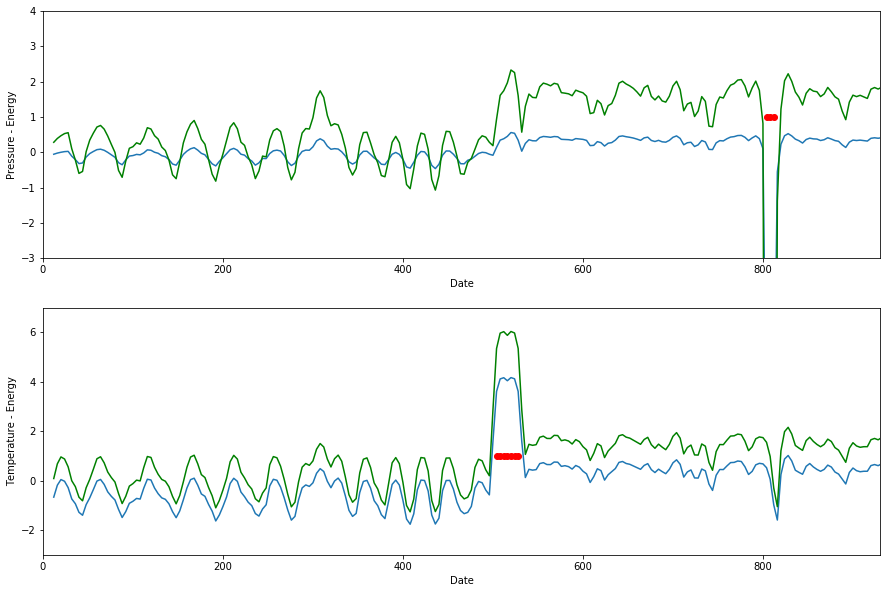

In [35]:
#EPS = np.dot(SxPS.T, freqsPS)
#EPS = np.log10(np.dot(SxPS.T, freqsPS))
EPS = np.log10(np.dot(SxPS.T, freqsPS))
ETS = np.log10(np.dot(SxTS.T, freqsTS))

f, ax = plt.subplots(2,1,figsize=(15,10))
ax[0].plot(timesPS, eps_zscore)
ax[0].plot(timesPS, EPS, color = 'green')
ax[0].set_ylim(-3, 4)
ax[0].set_xlim(0, 930)
ax[0].scatter(timesPS, eps_zscoreb, color = 'red')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Pressure - Energy')
ax[1].plot(timesPS, ets_zscore)
ax[1].plot(timesTS, ETS, color = 'green')
ax[1].set_ylim(-3, 7)
ax[1].set_xlim(0, 930)
ax[1].scatter(timesTS, ets_zscoreb, color = 'red')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Temperature - Energy')

Text(0, 0.5, 'Derivative Temperature')

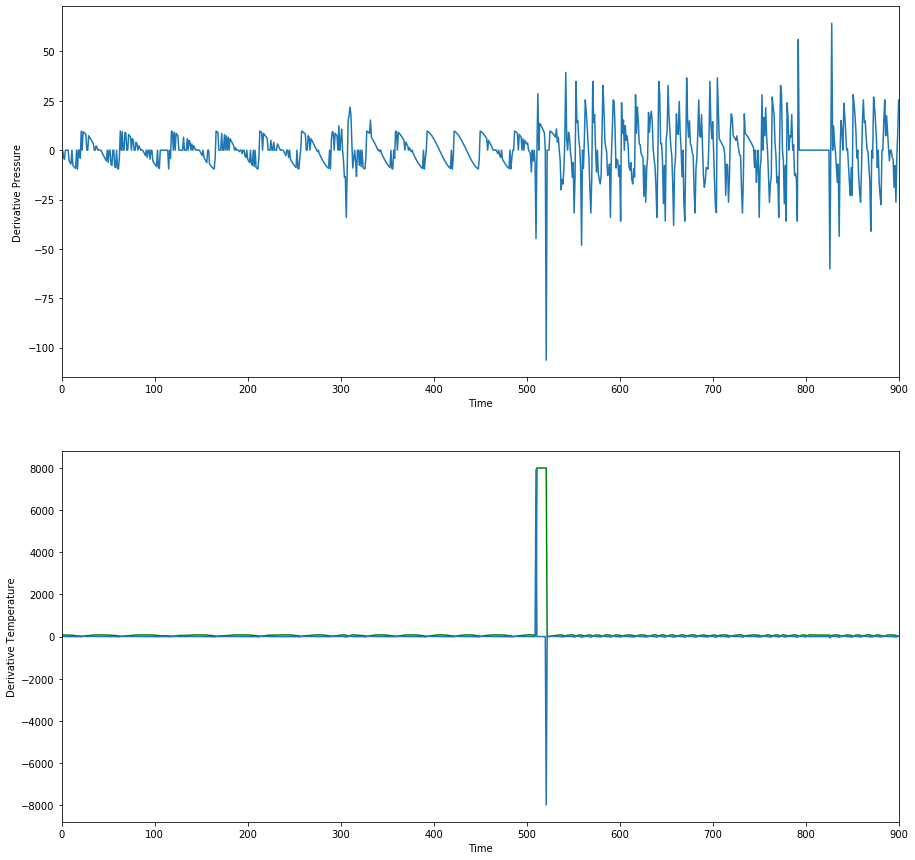

In [36]:
# look at the first discrete derivate (time)
temp_dvp = np.append(np.diff(df_temp['PRESSURE']),0)
temp_dvt = np.append(np.diff(df_temp['TEMPERATURE']),0)
temp_t = df_temp['TEMPERATURE'].values

temp_dt = (df_temp.index.values.astype(np.int64) -1569521100000000000) / 300000000000
fig, ax = plt.subplots(2, 1, figsize=(15,15))
ax[0].plot(temp_dt, temp_dvp)
ax[0].set_xlim(0, 900)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Derivative Pressure')
ax[1].plot(temp_dt, temp_t, color='green')
ax[1].plot(temp_dt, temp_dvt)
ax[1].set_xlim(0, 900)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Derivative Temperature')

In [37]:
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
#knn = KNN()
cblof = CBLOF(n_clusters=10, n_jobs=-1)
#pred = knn.fit_predict(temp_dvt.reshape(-1,1))
cblof.fit(temp_t.reshape(-1,1))
pred = cblof.predict(temp_t.reshape(-1,1))

In [38]:
#l_dvt = temp_dvt * pred
l_dvt = temp_t * pred
l_dvt[l_dvt == 0] = 'nan'

Text(0, 0.5, 'D Temperature')

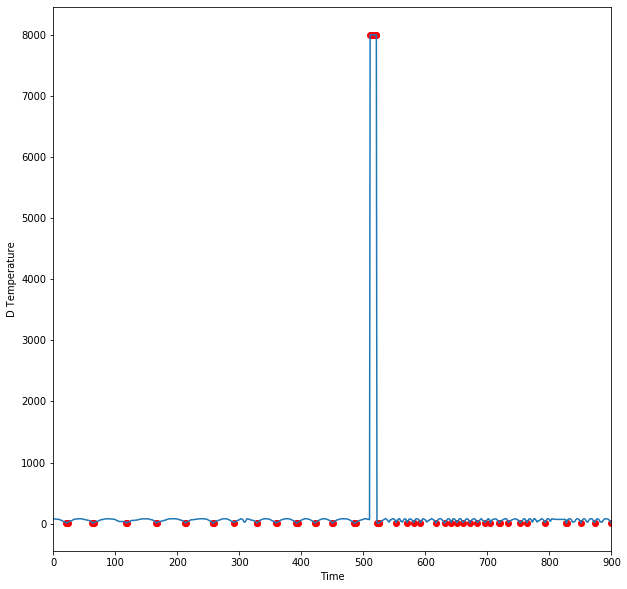

In [39]:
# neither KNN nor CBLOF (K-means) are really suitable it seems, but zscore would definitively do
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(temp_dt, temp_t)
ax.scatter(temp_dt, l_dvt, color = 'red')

ax.set_xlim(0, 900)
ax.set_xlabel('Time')
ax.set_ylabel('D Temperature')

#df_temp.plot(ax=ax[1], lw=.5, y='TEMPERATURE')
#ax[1].set_ylim(15, 120)
#ax[1].set_xlabel('Date')
#ax[1].set_ylabel('Temperature')

In [40]:
# Maybe windowing makes more sense - we have slices prepared in a previous step
# now we compare the 'shapes' of short functions
# Window size: 12
winsize = 12
slices2 = skiutil.view_as_windows(temperature, window_shape=(winsize,))
slices2.shape

(952, 12)

In [41]:
from pyod.models.cblof import CBLOF

cblofwin = CBLOF(n_clusters=40, n_jobs=-1)
cblofwin.fit(slices2)
predwin = cblofwin.predict(slices2)
preddec = cblofwin.decision_function(slices2)
    
# prepare scatterplot
predwin[predwin != 0] = 1
pred_t = predwin * temperature[winsize//2-1:temperature.size-winsize//2]
pred_t[pred_t == 0] = 'nan'
predwin2 = preddec
predwin2[predwin2 < 0.5] = 0
predwin2[predwin2 !=0] = 1
predwin2 = temperature[winsize//2-1:temperature.size-winsize//2] * predwin2
predwin2[predwin2 == 0] = 'nan'
predwin2.shape

(952,)

No handles with labels found to put in legend.


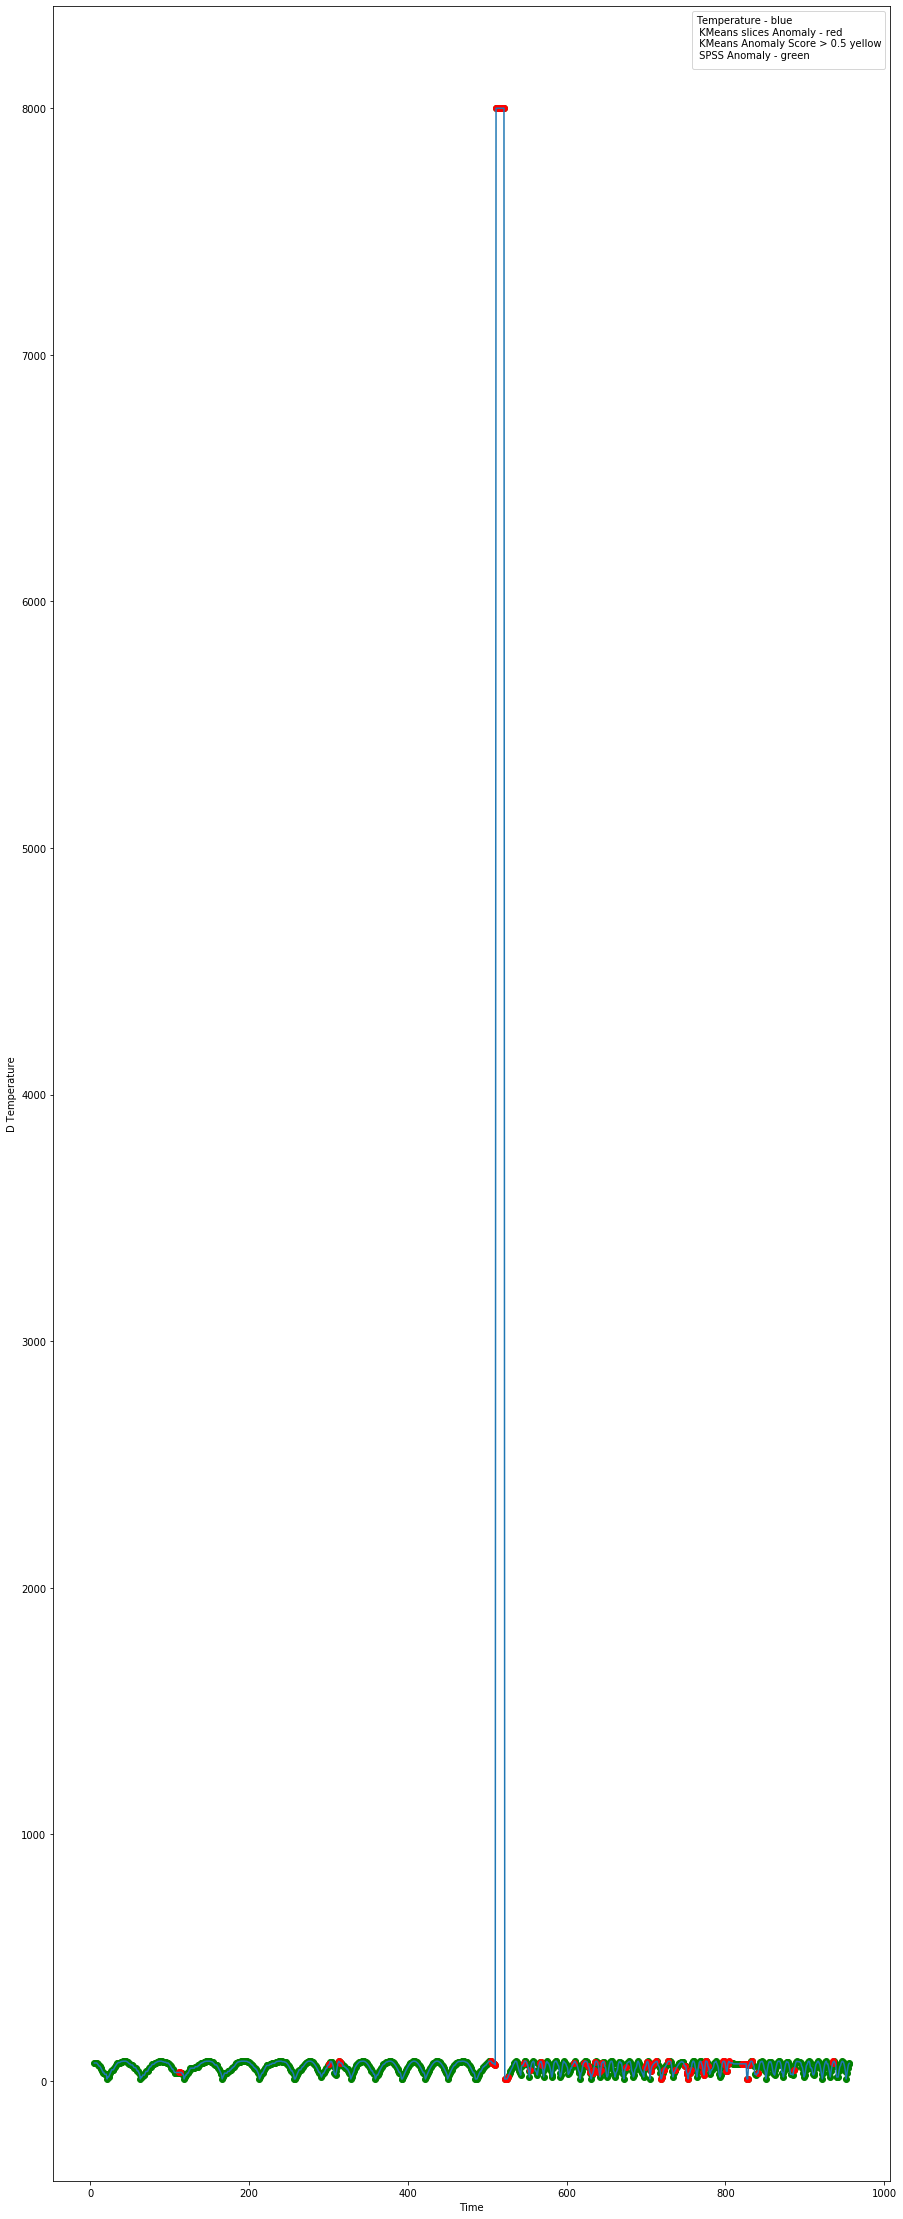

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(15,40))
ax.plot(temp_dt[winsize//2-1:temperature.size-winsize//2], temp_t[winsize//2-1:temperature.size-winsize//2])
ax.scatter(temp_dt[winsize//2-1:temperature.size-winsize//2], predwin2-0.2, color='green')
ax.scatter(temp_dt[winsize//2-1:temperature.size-winsize//2], pred_t, color = 'red')

#ax.set_xlim(0, 18.2)
ax.set_xlabel('Time')
ax.set_ylabel('D Temperature')
ax.legend(title='Temperature - blue\n KMeans slices Anomaly - red \n KMeans Anomaly Score > 0.5 yellow\n SPSS Anomaly - green')
